# Problem Definition

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).



Data Dictionary:

- Survived is self-explanatory. Whether the passenger survived or not. 0 = No, 1 = Yes

- Pclass is the ticket class and is definied by 1 = 1st, 2 = 2nd, 3 = 3rd. (Upper, Middle, Lower class)

- Sex is the gender of each passenger

- Age is the age in years. Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5	

- Sibsp is the # of siblings/spouses aboard the Titanic. Sibling = brother, sister, stepbrother, stepsister
and the Spouse = husband, wife (mistresses and fiancés were ignored)	

- Parch	is the # of parents/children aboard the Titanic. Parent = mother, father and Child = daughter, son, stepdaughter, stepson. Some children traveled only with a nanny, therefore parch=0 for them.	

- Ticket is the ticket #. 

- Fare is the passenger fare.

- Cabin	is the cabin number	

- Embarked is the Port of Embarkation	(C = Cherbourg, Q = Queenstown, S = Southampton)

# Most Recent Competition Ranking and Model Scores

Ranking:

1008 out of 14906 participants

Model Scores:

77.99 = LR (current entry)

77.7 = SVM

77.03 = KNN

75.59 = GBM

In [339]:
# Setting up our environment
import seaborn as sns
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import set_option
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [292]:
# load data 
train_set = pd.read_csv('train.csv') 
test_set = pd.read_csv('test.csv')

# concat train and test
titanic = pd.concat([train_set,test_set], ignore_index=True)

# Summarizing the Data using Descriptive Statistics and Data Visualization

In [293]:
# Displaying the dimensions of our data
print(titanic.shape)

(1309, 12)


We have 1309 instances to work with in the dataset and can confirm the data has 12 attributes including the class attribute. Let’s also look at the data types of each attribute in the dataset.

In [294]:
# Displaying the data types
titanic.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

You can see above that half of our attributes are of an 'object' data type and the other half are 'integer' with the exception of three 'floating-point' attributes. 

In [295]:
# head 
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.28,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.10,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,NaN,S


We can see that there are different scales of data as well as categorical and numerical attributes.

In [296]:
# statistical descriptions, change precision to 3 places
set_option('display.precision', 2)
titanic.describe(include = 'all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,1309.00,891.00,1309.00,1309,1309,1046.00,1309.00,1309.00,1309,1308.00,295,1307
unique,NaN,NaN,NaN,1307,2,NaN,NaN,NaN,929,NaN,186,3
top,NaN,NaN,NaN,"Connolly, Miss. Kate",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,2,843,NaN,NaN,NaN,11,NaN,6,914
mean,655.00,0.38,2.29,NaN,NaN,29.88,0.50,0.39,NaN,33.30,NaN,NaN
std,378.02,0.49,0.84,NaN,NaN,14.41,1.04,0.87,NaN,51.76,NaN,NaN
min,1.00,0.00,1.00,NaN,NaN,0.17,0.00,0.00,NaN,0.00,NaN,NaN
25%,328.00,0.00,2.00,NaN,NaN,21.00,0.00,0.00,NaN,7.90,NaN,NaN
50%,655.00,0.00,3.00,NaN,NaN,28.00,0.00,0.00,NaN,14.45,NaN,NaN
75%,982.00,1.00,3.00,NaN,NaN,39.00,1.00,0.00,NaN,31.27,NaN,NaN


Data that sticks out:

1. The passengers have an average age of 30 years old.

2. Most of the passengers were in the 3rd class on the Titanic.

Let’s take a quick look at the breakdown of some of the key attributes.

In [297]:
#Pclass distribution
print(titanic.groupby('Pclass').size())

Pclass
1    323
2    277
3    709
dtype: int64


Confirmed majority of the passengers in class 3 or the lower class. 

In [298]:
#Sex distribution
print(titanic.groupby('Sex').size())

Sex
female    466
male      843
dtype: int64


A majority of the passengers were male. 

In [299]:
#SibSp distribution
print(titanic.groupby('SibSp').size())

SibSp
0    891
1    319
2     42
3     20
4     22
5      6
8      9
dtype: int64


Large skew of Sibling and Spouse #'s between 0-1.

In [300]:
#Parch distribution
print(titanic.groupby('Parch').size())

Parch
0    1002
1     170
2     113
3       8
4       6
5       6
6       2
9       2
dtype: int64


Same can be said for the Parent and children numbers. Alot of children seem to have come onboard with just a nanny. 

In [301]:
#Embarked distribution
print(titanic.groupby('Embarked').size())

Embarked
C    270
Q    123
S    914
dtype: int64


Similar to the class distribution, we find alot of passengers embarking from Southampton. There may be a correlation there. 

In [302]:
# class distribution
print(titanic.groupby('Survived').size())

Survived
0.0    549
1.0    342
dtype: int64


Good distribution of cases versus non-cases. 

# Data Visualizations

Let’s look at visualizations of individual attributes. Let’s look at histograms of each attribute to get a sense of the data distributions.

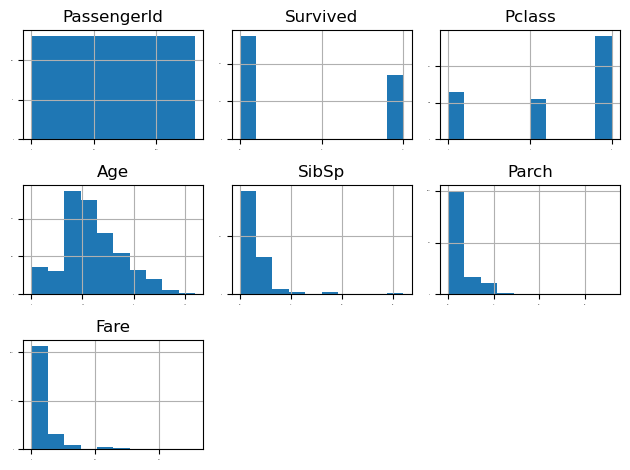

In [303]:
# histograms
titanic.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1)
plt.tight_layout()
plt.show()

In [304]:
#The skew results show a positive (right) or negative (left) skew. Values closer to zero show less skew.
skew = titanic.skew()
skew

/var/folders/6j/jkmq605x6ld06gw9z8nvb52m0000gn/T/ipykernel_1907/3500335714.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  skew = titanic.skew()


PassengerId    0.00
Survived       0.48
Pclass        -0.60
Age            0.41
SibSp          3.84
Parch          3.67
Fare           4.37
dtype: float64

We can see that the SibSp, Parch, and Fare attributes there are right-skewed distributions. We may be able to perform some log transformation here or at least experiment to see if that has a positive effect. Let’s take a look at the same perspective of the data using density plots.

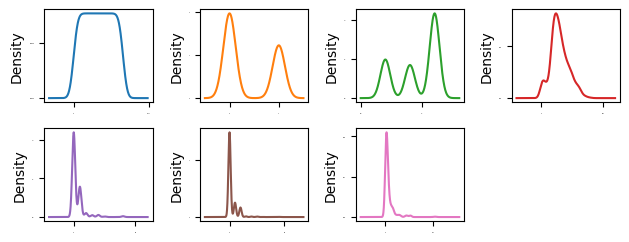

In [305]:
# density plot
titanic.plot(kind = 'density', subplots = True, layout = (4,4), sharex = False, \
sharey = False, legend = False, fontsize = 1)
plt.tight_layout()
plt.show()

This is useful and more visually appealing to the eyes. Let's visualize the individual data attributes grouped by the Survived attribute. 

<AxesSubplot:xlabel='Sex', ylabel='count'>

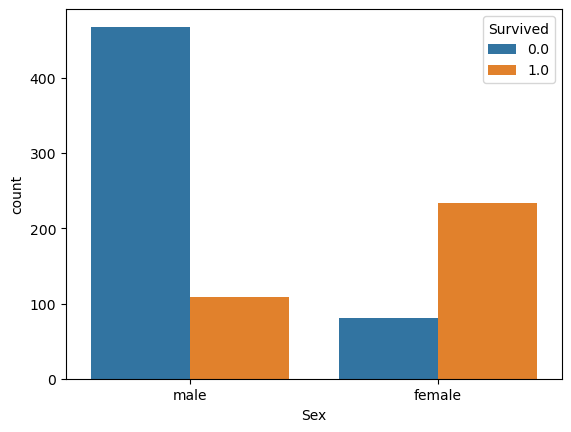

In [306]:
sns.countplot(data = titanic,x = 'Sex',hue='Survived')

As expected, the chances of survival for a female are higher than male. They wouldve been the first to get to safety along with children.  

<AxesSubplot:xlabel='Pclass', ylabel='count'>

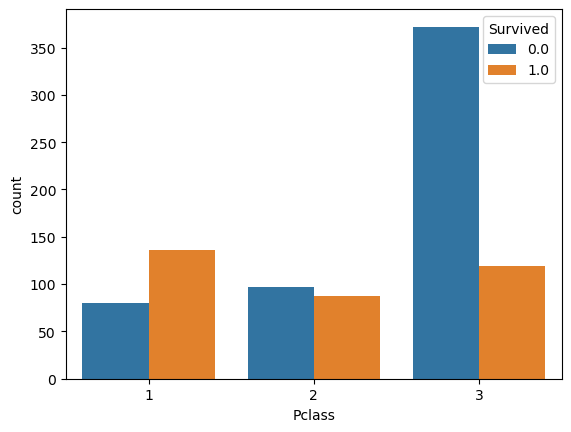

In [307]:
sns.countplot(data = titanic,x = 'Pclass',hue='Survived')

This prods an interesting question of:

Did wealthier passengers have a higher chance of survival? According to this plot, that may be the case. Note that there are less passengers total in first class due to it being expensive, so the ratio of survived to total passengers in first class is significant.

<AxesSubplot:xlabel='Embarked', ylabel='count'>

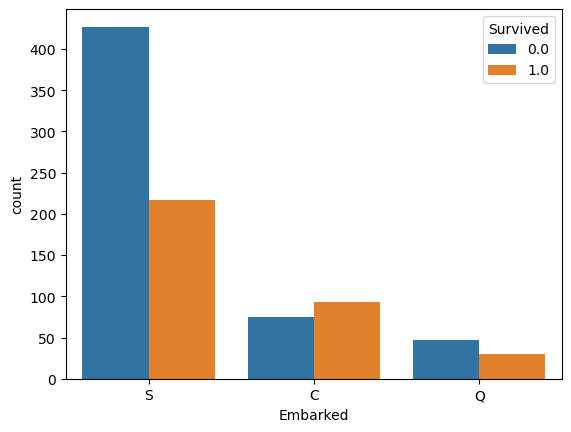

In [308]:
sns.countplot(data = titanic,x = 'Embarked',hue='Survived')

Southampton appears to be correlated to the lower class with a high rate of non-survival. Note that they appear as the largest group of survivors as well in the graph, but that is because they are the majority of population on the boat so these numbers will be skewed.

<AxesSubplot:xlabel='Fare', ylabel='count'>

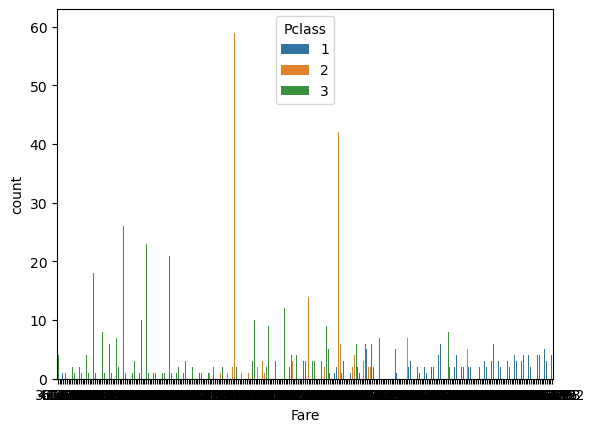

In [309]:
sns.countplot(data = titanic,x = 'Fare',hue='Pclass')

I wanted to see the grouping of Fare and Pclass to get an idea of what the data looked like. You can see that the 3rd class (green) paid the least and most likely got the poor cabin selection or no cabin at all, while the 1st class (blue) paid the highest prices. The Pclass and Fare attributes may be able to make up for the large amount of null values you will see below for the Cabin attribute. 

# Preparing the Data with Data Cleaning, Feature Selection, and Data Transforms

In [310]:
# Seeing which attributes hold null values and summing them up per attribute
print(titanic.isnull().sum())

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


We can see that the Age, Cabin, Embarked, and Fare attributes in the dataset have null values. The Survived attribute null values are factoring in the test set which obviously has no Survived attributes as we want to predict these. For this dataset:  

1. I will start off by dropping columns that are of no use to us.

2. I will look at the Age attribute more closely as 263 missing values is 20% of our data for that attribute so that could create bias if we handle it lazily.

3. The Embarked attribute only has 2 missing values so I will fill these with the mode of the attribute. 

4. The Cabin attribute has 1014 out of 1039 potential values null which is a bit concerning as that is 97% of our data for that attribute. I will drop this attribute, although it is unfortunate because this has the location of the Cabin in the first letter of the value. Still, it does not meet our threshold standards of 20%-30% null. 

5. We can most likely shrink the Name attribute down to a "Mr. and Mrs." style of column or status titles if they have them.

6. We will combine or revise the SibSp and Parch features to exploit the family size aspect of the data. 

In [311]:
titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [312]:
# Dropping a few attributes from our dataset 
titanic.drop(['PassengerId', 'Ticket', 'Cabin'], axis = 1, inplace = True)

In [313]:
titanic.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [314]:
titanic["Age"].describe()

count    1046.00
mean       29.88
std        14.41
min         0.17
25%        21.00
50%        28.00
75%        39.00
max        80.00
Name: Age, dtype: float64

With a mean age of 30, filling these in with the mean could tip the bias so we will use some creative ideas to fill these values. I am going to group by Pclass and Sex and then chain that to the Age median. 

In [315]:
pclass_sex_grouping = titanic.groupby(['Pclass', 'Sex'])['Age']. median()

pclass_sex_grouping

Pclass  Sex   
1       female    36.0
        male      42.0
2       female    28.0
        male      29.5
3       female    22.0
        male      25.0
Name: Age, dtype: float64

In [316]:
titanic["Age"] = titanic.groupby(['Pclass', 'Sex'])['Age'].apply(lambda age: age.fillna(age.median()))
print(titanic["Age"].isnull().sum())
print(titanic["Age"].describe())

0
count    1309.00
mean       29.26
std        13.22
min         0.17
25%        22.00
50%        26.00
75%        36.00
max        80.00
Name: Age, dtype: float64


You can see that the null values have been filled in with the appropriate age mean for our groupings. This has dropped the Age mean down the tiniest bit but distributed our values alot more uniform than if we were to use the original Age attribute mean. While I am here, I will create a categorical Age group attribute to increase the potential of this attribute, then I will handle the missing values in the Embarked attribute.

In [317]:
titanic['age_group'] = titanic.loc[titanic['Age']<=14, 'age_group'] = 'child'
titanic.loc[titanic['Age'].between(14,24), 'age_group'] = 'youth'
titanic.loc[titanic['Age'].between(24,64), 'age_group'] = 'adult'
titanic.loc[titanic['Age']>64, 'age_group'] = 'senior'
print(titanic['age_group'].value_counts())
print(titanic.columns)

adult     871
youth     326
child      99
senior     13
Name: age_group, dtype: int64
Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'age_group'],
      dtype='object')


In [318]:
# We can now drop the Age column
titanic.drop(['Age'], axis = 1)

,Survived,Pclass,Name,Sex,SibSp,Parch,Fare,Embarked,age_group
0,0.0,3,"Braund, Mr. Owen Harris",male,1,0,7.25,S,youth
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,71.28,C,adult
2,1.0,3,"Heikkinen, Miss. Laina",female,0,0,7.92,S,adult
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,53.10,S,adult
4,0.0,3,"Allen, Mr. William Henry",male,0,0,8.05,S,adult
...,...,...,...,...,...,...,...,...,...
1304,NaN,3,"Spector, Mr. Woolf",male,0,0,8.05,S,adult
1305,NaN,1,"Oliva y Ocana, Dona. Fermina",female,0,0,108.90,C,adult
1306,NaN,3,"Saether, Mr. Simon Sivertsen",male,0,0,7.25,S,adult
1307,NaN,3,"Ware, Mr. Frederick",male,0,0,8.05,S,adult


In [319]:
# Filling the null value in the Embarked attribute with the first mode it finds
titanic['Embarked'] = titanic['Embarked'].fillna(titanic['Embarked'].mode()[0])
titanic['Embarked'].isnull().sum()

0

I will now parse the Name attribute in order to extract relevant information we can exploit.

In [320]:
titanic["Name"].unique()

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina', ..., 'Saether, Mr. Simon Sivertsen',
       'Ware, Mr. Frederick', 'Peter, Master. Michael J'], dtype=object)

In [321]:
# create a new feature to extract title names from the Name column
titanic['Title'] = titanic["Name"].apply(lambda name: name.split(',')[1].split('.')[0].strip())
titanic['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Title, dtype: int64

Let's now consolidate this even more by creating a dictionary and mapping these values according to status. This involved looking up certain titles to see their meaning.

In [322]:
# Creating a dictionary so we can map these values into a more consolidated status
new_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"
}

titanic["Title"] = titanic["Title"].map(new_titles)

In [323]:
titanic = titanic.drop(["Name"], axis = 1)
titanic["Title"].value_counts()

Mr         757
Miss       262
Mrs        200
Master      61
Officer     23
Royalty      6
Name: Title, dtype: int64

We will now consolidate the SibSp and Parch attributes to an attribute named Family_size.

In [324]:
# size of the families factoring in the passenger as well
titanic['Family_size'] = titanic["Parch"] + titanic["SibSp"] + 1
titanic['Family_size'].value_counts()

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: Family_size, dtype: int64

We will now deal with the singular null value with the Fare attribute by using the attribute column's mean. While we are here let's log transform this attribute and see if it corrects the skewness.

In [325]:
titanic["Fare"] = titanic["Fare"].fillna(titanic["Fare"].mean())
print(titanic["Fare"].isnull().sum())

0


<AxesSubplot:>

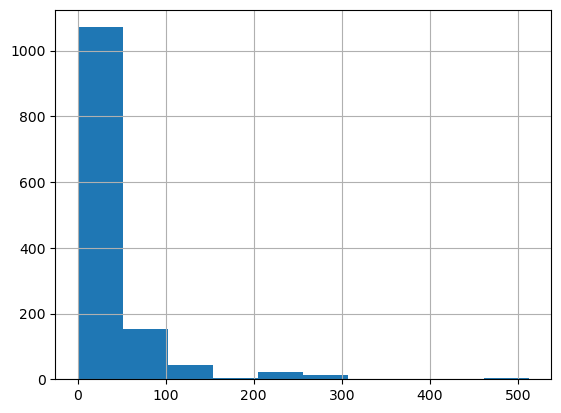

In [326]:
titanic['Fare'].hist()

<AxesSubplot:>

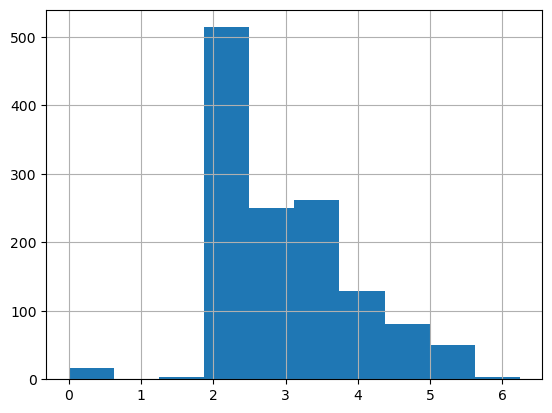

In [327]:
titanic['Fare'] = np.log(titanic['Fare'] + 1)
titanic['Fare'].hist()

This definitely shifted us to a more centered distribution. We are now going to want to dummy our categorical attributes in order for the algorithms to be able to process them. We are also going to turn the Male and Female values in the Sex attribute into integers.  

In [328]:
# Remapping the string values to integer values
gender = {'male': 0, 'female':1}
titanic["Sex"] = titanic["Sex"].map(gender)

# Creating dummy variables for the categorical features
Pclass_dummy = pd.get_dummies(titanic["Pclass"], prefix="Pclass")
Title_dummy = pd.get_dummies(titanic["Title"], prefix="Title")
Embarked_dummy = pd.get_dummies(titanic["Embarked"], prefix="Embarked")
Age_group_dummy = pd.get_dummies(titanic["age_group"], prefix="age_group")

# Combining the dummy variables for each attribute to our original dataset
titanic = pd.concat([titanic, Pclass_dummy, Title_dummy, \
                             Embarked_dummy, Age_group_dummy], axis = 1)

# Removing the previous categorical columns to avoid duplication
titanic.drop(['Pclass', 'Title', 'Embarked', 'Age', 'age_group'], axis=1, inplace=True)

In [329]:
titanic.head()

,Survived,Sex,SibSp,Parch,Fare,Family_size,Pclass_1,Pclass_2,Pclass_3,Title_Master,...,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S,age_group_adult,age_group_child,age_group_senior,age_group_youth
0,0.0,0,1,0,2.11,2,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
1,1.0,1,1,0,4.28,2,1,0,0,0,...,1,0,0,1,0,0,1,0,0,0
2,1.0,1,0,0,2.19,1,0,0,1,0,...,0,0,0,0,0,1,1,0,0,0
3,1.0,1,1,0,3.99,2,1,0,0,0,...,1,0,0,0,0,1,1,0,0,0
4,0.0,0,0,0,2.20,1,0,0,1,0,...,0,0,0,0,0,1,1,0,0,0


We have officially finished cleaning our dataset and we did some feature engineering along the way. These processes could be split into separate tasks but I find that they blend into each other most of the time. Now we can move onto evaluating algorithms. 

# Creating a Validation/Test Dataset

It is a good idea to use a validation hold-out set. This is a sample of the data that we hold back from our analysis and modeling. We use it right at the end of our project to confirm the accuracy of our final model. It is a smoke test that we can use to see if we messed up and to give us confidence on our estimates of accuracy on unseen data. We will use 70% of the dataset for modeling and hold back 30% for validation.

In [330]:
# create train and test data
train = titanic[0:891]
test = titanic[891: ]
test = test.drop(['Survived'], axis = 1)

# Make the Survived column an integer
train['Survived'] = train['Survived'].astype(int)

Y = train['Survived']
X = train.drop('Survived', axis = 1)
seed = 7
test_size = 0.30


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size, random_state = seed)

# Evaluate Algorithms: Baseline

Let’s design our test harness. We will use 5-fold cross-validation. We will evaluate algorithms using the accuracy metric. This will give us a quick idea of how correct a given model is, and is more useful on binary classification problems like this one.

In [331]:
# Test options and evaluation metric
num_folds = 5
scoring = 'accuracy'

Let’s create a baseline of performance on this problem and spot-check a number of different algorithms. We will select a suite of different algorithms capable of working on this classification problem. The 4 algorithms selected include:

Linear Algorithm: 

- Logistic Regression (LR).

Non-linear Algorithms: 

- Classification and Regression Trees (CART), Support Vector Machines (SVM), and k-Nearest Neighbors (KNN).

In [332]:
# Spot Check Algorithms 
models = []
models.append(('LR', LogisticRegression(solver = 'liblinear')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC(gamma = 'auto')))

The algorithms all use default tuning parameters. Let’s compare the algorithms. We will display the mean and standard deviation of accuracy for each algorithm as we calculate it and collect the results for use later.

In [333]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits = num_folds, random_state = seed, shuffle = True)
    cv_results = cross_val_score(model, X_train, Y_train, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.839535 (0.017840)
KNN: 0.823445 (0.011141)
CART: 0.809084 (0.025394)
SVM: 0.847574 (0.019166)


/Users/multi-millionaire/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/multi-millionaire/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the val

Mean Accuracy Values and Standard Deviations:

LR: 0.839535 (0.017840)

KNN: 0.823445 (0.011141)

CART: 0.810697 (0.030913)

SVM: 0.847574 (0.019166)

Logistic Regression and SVM are obvious leaders for this first test. Let's plot a comparison of all the algorithms results.

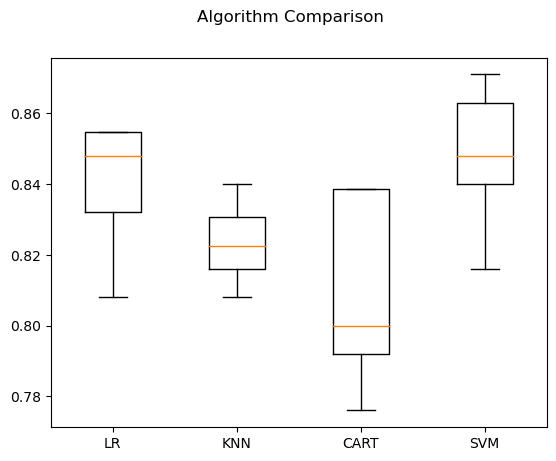

In [334]:
# Compare the Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Evaluate Algorithms: Standardize Data

Let’s evaluate the same algorithms with a standardized copy of the dataset. This is where the data is transformed such that each attribute has a mean value of zero and a standard deviation of one. We also need to avoid data leakage when we transform the data. A good way to avoid leakage is to use pipelines that standardize the data and build the model for each fold in the cross-validation test harness. That way we can get a fair estimation of how each model with standardized data might perform on unseen data.

In [343]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', RobustScaler()), \
                                       ('LR', LogisticRegression(solver = 'liblinear'))])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', RobustScaler()), \
                                        ('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', RobustScaler()), \
                                        ('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', RobustScaler()), \
                                        ('SVM', SVC(gamma = 'auto'))])))
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits = num_folds, random_state = seed, shuffle = True)
    cv_results = cross_val_score(model,X_train, Y_train, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: 0.839523 (0.012969)
ScaledKNN: 0.817032 (0.005390)
ScaledCART: 0.812323 (0.034012)


/Users/multi-millionaire/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/multi-millionaire/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the val

ScaledSVM: 0.847574 (0.019166)


New results with StandardScaler:

ScaledLR: 0.836310 (0.016160)

ScaledKNN: 0.837948 (0.020018)

ScaledCART: 0.815523 (0.034231)

ScaledSVM: 0.842761 (0.021415)

New results with Normalizer:

ScaledLR: 0.841161 (0.025654)
    
ScaledKNN: 0.820310 (0.031450)
    
ScaledCART: 0.818671 (0.013316)
    
ScaledSVM: 0.805923 (0.046870)

New results with RobustScaler:

ScaledLR: 0.839523 (0.012969)

ScaledKNN: 0.817032 (0.005390)

ScaledCART: 0.812323 (0.034012)

ScaledSVM: 0.847574 (0.019166)

Previous results with no scaler: 

LR: 0.839535 (0.017840)

KNN: 0.823445 (0.011141)

CART: 0.810697 (0.030913)

SVM: 0.847574 (0.019166)

Running the example provides the results listed above. There is not much benefit from scaling here so I will avoid using a scaler onwards from here. 

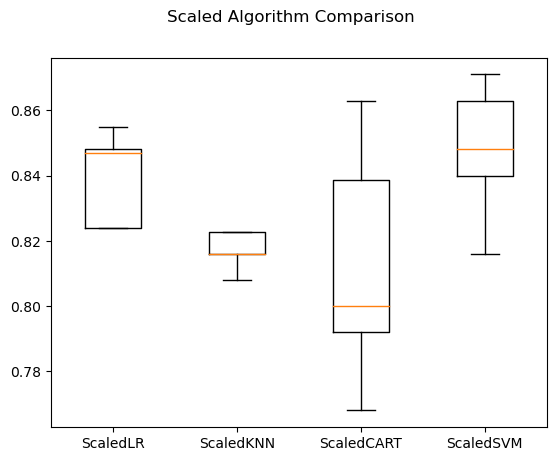

In [344]:
# Compare the Algorithms
fig = plt.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Algorithm Tuning

In this section we investigate tuning the parameters for the top 3 algorithms that show promise from the spot-checking in the previous section:

1. SVM

2. LR

3. KNN

# Tuning KNN

We can start off by tuning the number of neighbors for KNN. The default number of neighbors is 7. Below we try all odd values of k from 1 to 21, covering the default value of 7. Each k value is evaluated using 5-fold cross-validation on the training standardized dataset.

In [345]:
# Tune scaled KNN
neighbors = [1,3,5,7,9,11,13,15,17,19,21]
param_grid = dict(n_neighbors = neighbors)
model = KNeighborsClassifier()
kfold = KFold(n_splits = num_folds, random_state = seed, shuffle = True)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = scoring, cv = kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/multi-millionaire/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/multi-millionaire/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the val

Best: 0.845948 using {'n_neighbors': 9}
0.793019 (0.028737) with: {'n_neighbors': 1}
0.815471 (0.024937) with: {'n_neighbors': 3}
0.823445 (0.011141) with: {'n_neighbors': 5}
0.844335 (0.024902) with: {'n_neighbors': 7}
0.845948 (0.015152) with: {'n_neighbors': 9}
0.826697 (0.023181) with: {'n_neighbors': 11}
0.834735 (0.023143) with: {'n_neighbors': 13}
0.834748 (0.024653) with: {'n_neighbors': 15}
0.833135 (0.022964) with: {'n_neighbors': 17}
0.834748 (0.030290) with: {'n_neighbors': 19}
0.836348 (0.027664) with: {'n_neighbors': 21}


/Users/multi-millionaire/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/multi-millionaire/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the val

Best: 0.845948 using {'n_neighbors': 9}

We can print out the configuration that resulted in the highest accuracy as well as the accuracy of all values tried. Running the example we see the results above. We can see that the optimal configuration is K=9.

# Tuning SVM

We can tune two key parameters of the SVM algorithm, the value of C (how much to relax the margin) and the type of kernel. The default for SVM (the SVC class) is to use the Radial Basis Function (RBF) kernel with a C value set to 1.0. Like with KNN, we will perform a grid search using 5-fold cross-validation. We will try a number of simpler kernel types and C values with less bias and more bias (less than and more than 1.0 respectively).

In [346]:
# Tune scaled SVM
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C = c_values, kernel = kernel_values)
model = SVC(gamma = 'auto')
kfold = KFold(n_splits = num_folds, random_state = seed, shuffle = True)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = scoring, cv = kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.850774 using {'C': 1.3, 'kernel': 'rbf'}
0.833123 (0.021955) with: {'C': 0.1, 'kernel': 'linear'}
0.773690 (0.016899) with: {'C': 0.1, 'kernel': 'poly'}
0.839548 (0.018482) with: {'C': 0.1, 'kernel': 'rbf'}
0.630929 (0.043571) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.834723 (0.020253) with: {'C': 0.3, 'kernel': 'linear'}
0.802529 (0.024897) with: {'C': 0.3, 'kernel': 'poly'}
0.847574 (0.019166) with: {'C': 0.3, 'kernel': 'rbf'}
0.784994 (0.025902) with: {'C': 0.3, 'kernel': 'sigmoid'}
0.836323 (0.018987) with: {'C': 0.5, 'kernel': 'linear'}
0.810581 (0.022584) with: {'C': 0.5, 'kernel': 'poly'}
0.847574 (0.019166) with: {'C': 0.5, 'kernel': 'rbf'}
0.788194 (0.022376) with: {'C': 0.5, 'kernel': 'sigmoid'}
0.833123 (0.021917) with: {'C': 0.7, 'kernel': 'linear'}
0.842710 (0.017154) with: {'C': 0.7, 'kernel': 'poly'}
0.847574 (0.019166) with: {'C': 0.7, 'kernel': 'rbf'}
0.788155 (0.020987) with: {'C': 0.7, 'kernel': 'sigmoid'}
0.833123 (0.021917) with: {'C': 0.9, 'kernel': 'linear'

Best: 0.850774 using {'C': 1.3, 'kernel': 'rbf'}

Running the example prints out the best configuration, the accuracy as well as the accuracies for all configuration combinations. We can see the most accurate configuration was SVM with an rbf kernel and a C value of 1.3.

# Tuning LR

In [348]:
# Tune scaled LR
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
penalties = ['l1', 'l2' , 'elasticnet', 'None']
class_weight = ['balanced', 'None']
max_iter = [100,200,300]
param_grid = dict(C = c_values, solver = solvers, penalty = penalties, \
                 class_weight = class_weight, max_iter = max_iter)
model = LogisticRegression()
kfold = KFold(n_splits = num_folds, random_state = seed, shuffle = True)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = scoring, cv = kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/multi-millionaire/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/multi-millionaire/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/multi-millionaire/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/multi-millionaire/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/multi-millionaire/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Best: 0.839548 using {'C': 0.5, 'class_weight': 'None', 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
nan (nan) with: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'lbfgs'}
0.812232 (0.015336) with: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
nan (nan) with: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'newton-cg'}
nan (nan) with: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'newton-cholesky'}
nan (nan) with: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'sag'}
0.805794 (0.016976) with: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
0.821845 (0.016917) with: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.817045 (0.014285) with: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty'

/Users/multi-millionaire/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5400 fits failed out of a total of 7200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/multi-millionaire/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/multi-millionaire/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/multi-millionaire/opt/anaconda3/lib/python3.9/si

Best: 0.839548 using {'C': 0.5, 'class_weight': 'None', 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}

Running the example prints out the best configuration, the accuracy as well as the accuracies for all configuration combinations. We can see the most accurate configuration was saga with a max iteration of 100 and a penalty of l1.

After Tuning:

SVM: 0.850774

GBM: 0.847600

KNN: 0.845948

LR: 0.839548

Before Tuning:

SVM: 0.847574 (0.019166)

GBM: 0.845987

LR: 0.839535 (0.017840)

KNN: 0.823445 (0.011141)

# Ensemble Methods

Another way that we can improve the performance of algorithms on this problem is by using ensemble methods. In this section we will evaluate four different ensemble machine learning algorithms, two boosting and two bagging methods:

• Boosting Methods: AdaBoost (AB) and Gradient Boosting (GBM).

• Bagging Methods: Random Forests (RF) and Extra Trees (ET).

We will use the same test harness as before, 5-fold cross-validation. No data standardization is used in this case because all four ensemble algorithms are based on decision trees that are less sensitive to data distributions.

In [349]:
# ensembles
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier(n_estimators = 10)))
ensembles.append(('ET', ExtraTreesClassifier(n_estimators = 10)))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits = num_folds, random_state = seed, shuffle = True)
    cv_results = cross_val_score(model, X_train, Y_train, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

AB: 0.833058 (0.016434)
GBM: 0.845987 (0.021227)
RF: 0.813884 (0.021105)
ET: 0.813845 (0.015065)


Running the example provides the following accuracy scores above. We can plot the distribution of accuracy scores across the cross-validation folds.

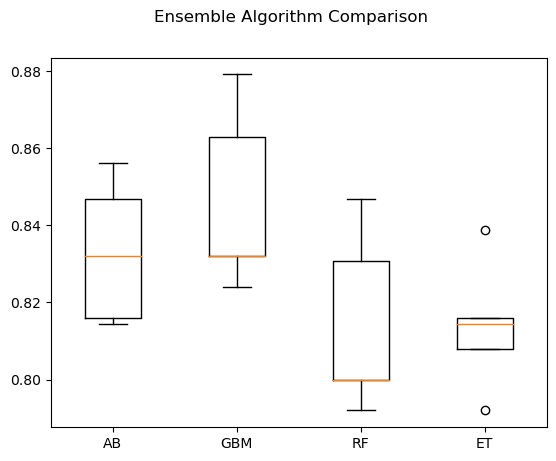

In [350]:
# Compare the Algorithms 
fig = plt.figure()
fig.suptitle('Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

The results suggest GBM may be worthy of further study.

# Tuning GBM

In [351]:
# Tune scaled GBM
loss = ['log_loss', 'exponential']
learning_rate = [0.1, 0.3]
n_estimators = [100,200,300]
criterion = ['friedman_mse', 'squared_error']
param_grid = dict(loss = loss, learning_rate = learning_rate, \
                 n_estimators = n_estimators, criterion = criterion)
model = GradientBoostingClassifier()
kfold = KFold(n_splits = num_folds, random_state = seed, shuffle = True)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = scoring, cv = kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/multi-millionaire/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/multi-millionaire/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/multi-millionaire/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 525, in fit
    self._check_params()
  File "/Users/multi-millionaire/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 282, in _che

Best: 0.847600 using {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 300}
nan (nan) with: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'log_loss', 'n_estimators': 100}
nan (nan) with: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'log_loss', 'n_estimators': 200}
nan (nan) with: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'log_loss', 'n_estimators': 300}
0.838013 (0.033619) with: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}
0.844413 (0.032637) with: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 200}
0.847600 (0.030457) with: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 300}
nan (nan) with: {'criterion': 'friedman_mse', 'learning_rate': 0.3, 'loss': 'log_loss', 'n_estimators': 100}
nan (nan) with: {'criterion': 'friedman_mse', 'learning_rate': 0.3, 'loss': 'log_

Best: 0.847600 using {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 300}

Running the example prints out the best configuration, the accuracy as well as the accuracies for all configuration combinations. We can see the most accurate configuration was friedman_mse with a 300 estimators, a learning rate of 0.1, and a loss of exponential.

# Finalize Model for SVM

In this section we will finalize the models by training them on the entire training dataset and make predictions for the hold-out validation dataset to confirm our findings.

In [352]:
# prepare the model 
svm = SVC(C = 1.3, kernel = 'rbf', gamma = 'auto')
svm.fit(X_train, Y_train)

#estimate the accuracy on the validation dataset
predictions = svm.predict(X_test)
accuracy_score_svm = round(accuracy_score(Y_test, predictions) * 100, 2)
print(accuracy_score_svm)
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

77.24
[[135  21]
 [ 40  72]]
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       156
           1       0.77      0.64      0.70       112

    accuracy                           0.77       268
   macro avg       0.77      0.75      0.76       268
weighted avg       0.77      0.77      0.77       268



# Final Model for LR

In [354]:
# prepare the model 
lr = LogisticRegression(C = 0.5, max_iter = 100, penalty = 'l1', solver = 'saga')
lr.fit(X_train, Y_train)

#estimate the accuracy on the validation dataset
predictions = lr.predict(X_test)
accuracy_score_lr = round(accuracy_score(Y_test, predictions) * 100, 2)
print(accuracy_score_lr)
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

77.99
[[137  19]
 [ 40  72]]
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       156
           1       0.79      0.64      0.71       112

    accuracy                           0.78       268
   macro avg       0.78      0.76      0.77       268
weighted avg       0.78      0.78      0.78       268



/Users/multi-millionaire/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Final Model for GBM

In [356]:
# prepare the model for GBM
gbm = GradientBoostingClassifier(criterion = 'friedman_mse' \
                                   , learning_rate = 0.1, loss = 'exponential', \
                                   n_estimators = 300)
gbm.fit(X_train, Y_train)

#estimate the accuracy on the validation dataset
predictions = gbm.predict(X_test)
accuracy_score_gbm = round(accuracy_score(Y_test, predictions) * 100, 2)
print(accuracy_score_gbm)
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

78.73
[[137  19]
 [ 38  74]]
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       156
           1       0.80      0.66      0.72       112

    accuracy                           0.79       268
   macro avg       0.79      0.77      0.77       268
weighted avg       0.79      0.79      0.78       268



# Final Model for KNN

In [355]:
# prepare the model for KNN
knn = KNeighborsClassifier(n_neighbors = 15)
knn.fit(X_train, Y_train)

#estimate the accuracy on the validation dataset
predictions = knn.predict(X_test)
accuracy_score_knn = round(accuracy_score(Y_test, predictions) * 100, 2)
print(accuracy_score_knn)
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

76.12
[[137  19]
 [ 45  67]]
              precision    recall  f1-score   support

           0       0.75      0.88      0.81       156
           1       0.78      0.60      0.68       112

    accuracy                           0.76       268
   macro avg       0.77      0.74      0.74       268
weighted avg       0.76      0.76      0.75       268



/Users/multi-millionaire/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Let's consolidate our individual model accuracy scores below and pick the best one. 

In [357]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Gradient Boosting Classifier', \
              'Logistic Regression', 'KNN'],
    'Score': [accuracy_score_svm, accuracy_score_gbm, accuracy_score_lr, \
              accuracy_score_knn]})
models.sort_values(by='Score', ascending=False)

,Model,Score
1,Gradient Boosting Classifier,78.73
2,Logistic Regression,77.99
0,Support Vector Machines,77.24
3,KNN,76.12


# Final Summary

Gradient Boosting Classifier came out on top as the most accurate on our test set. I will submit all 4 models as entries though and then go back to the drawing board. I have a hunch that our feature set could use some work.

In [364]:
#set ids as PassengerId and predict survival 
ids = test_set.PassengerId
predictions = knn.predict(test)

#set the output as a dataframe and convert to csv file named submission.csv
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('submission.csv', index=False)

/Users/multi-millionaire/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [365]:
output.head(20)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
